**INFO: This is the first notebook I am sharing and I am quite new at this field so I would appreciate any suggestions/comments!**

### Problem definition

Predicting diamond prices by their cut, color, clarity and othe attributes.

### Data

This dataset contains prices and other attributes of about 54,000 diamonds. The data is gathered in one CSV file.

Feature description:

* **carat** - weight of the diamond (0.2--5.01)

* **cut** - quality of the cut (Fair, Good, Very Good, Premium, Ideal)

* **color** - diamond colour, from J (worst) to D (best)

* **clarity** - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

* **depth** - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

* **table** - width of top of diamond relative to widest point (43--95)

* **price** - price in US dollars (326-18,823 US Dollars)

* **x** - length in mm (0--10.74)

* **y** - width in mm (0--58.9)

* **z** - depth in mm (0--31.8)

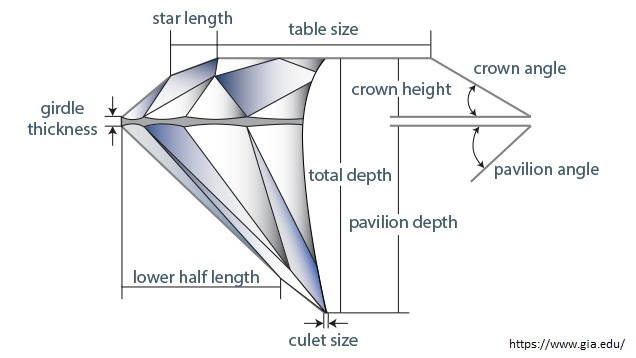 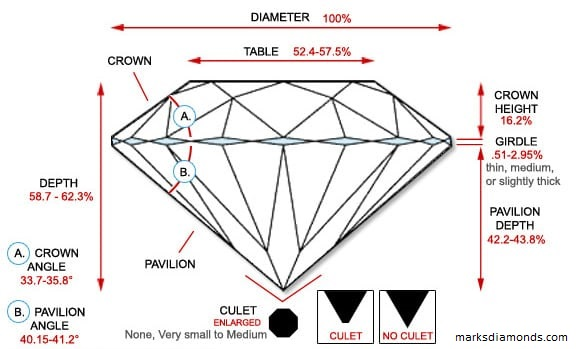


In [ ]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Load the data

In [ ]:
df = pd.read_csv('../input/diamonds/diamonds.csv', index_col=[0])

### Data exploration (EDA)

In [ ]:
df.head(20)

In [ ]:
df.tail(20)

In [ ]:
# Let's get some basic information about dataset
df.info()

### The key thing to get from here is that:
* We have 10 column from which 7 of them are numerical and 3 of them are object types, so we will have to change categorical variables into numbers
* We have no null values (but that doesn't mean all of them are with correct input)

In [ ]:
# Just to make sure let's check null values
df.isna().sum()

In [ ]:
# Let's see some descriptive statistics
df.describe()

In [ ]:
# Everything looks normal besides that there are 0 values for dimensions (x, y, z). We have to take a closer look at that.
# First let's see how many are there:
df.loc[(df.x==0) | (df.y==0) | (df.z==0)]

In [ ]:
# There is not so many of them so for now we can remove those examples
cond = df[(df["x"]==0) | (df["y"]==0) | (df["z"]==0)].index
df.drop(cond, inplace=True)

In [ ]:
# Let's make sure everything went well:
df.loc[(df.x==0) | (df.y==0) | (df.z==0)], df.shape

### As we can see there are 53920 instead of 53940 examples so everything is ok.

### Filling and turning categorical variables into numbers

In [ ]:
# Check for columns which aren't numeric
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

In [ ]:
# Turning categorical variables into numbers
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = pd.Categorical(content).codes+1

pd.Categorical(df["cut"]).codes, pd.Categorical(df["color"]).codes, pd.Categorical(df["clarity"]).codes,  

In [ ]:
# Now all of the features are presented as numbers
df.head()

In [ ]:
# Now let's see how the diamonds attributes corelates with each other
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Correlation heatmap - Diamonds attributes', fontdict={'fontsize':18}, pad=15)
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

#### As we can see on the correlation matrix there is a strong positive correlation between price and weight (carat) and price and size (x, y, z) of a diamond. The other attributes don't have strong positive or negative correlation. On other features we should focus when comparing diamonds with similar size and weight.

In [ ]:
# Let's plot numerical variables
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2,
                                                       ncols=3,
                                                       figsize=(15,10))
# Price vs weight plot
scatter = ax0.scatter(x=df["price"],
                      y=df["carat"],
                      color="red")
ax0.set(title="Price vs weight[carat]",
        xlabel="Price",
        ylabel="Weight[carat]")

# Price vs depth plot
scatter = ax1.scatter(x=df["price"],
                      y=df["depth"],
                      color="green")
ax1.set(title="Price vs depth percentage",
        xlabel="Price",
        ylabel="Depth")

# Price vs table plot
scatter = ax2.scatter(x=df["price"],
                      y=df["table"],
                      color="blue")
ax2.set(title="Price vs table size",
        xlabel="Price",
        ylabel="Table")

# Price vs x-dimension plot
scatter = ax3.scatter(x=df["price"],
                      y=df["x"],
                      color="orange")
ax3.set(title="Price vs x-length dimension",
        xlabel="Price",
        ylabel="x-length")

# Price vs y-dimension plot
scatter = ax4.scatter(x=df["price"],
                      y=df["y"],
                      color="orange")
ax4.set(title="Price vs y-width dimension",
        xlabel="Price",
        ylabel="y-width")

# Price vs z-dimension plot
scatter = ax5.scatter(x=df["price"],
                      y=df["z"],
                      color="orange")
ax5.set(title="Price vs z-depth dimension",
        xlabel="Price",
        ylabel="z-depth");

#### We have to take a closer look at outliers. In the case of dimensions (x, y, z) together with table size, there are probably wrong inputs. With the weight and depth there are only a few outliers so we can assume that those are very rare cases so we can skip them.


In [ ]:
names=['table', 'x', 'y', 'z']
ncols=len(names)
fig, ax = plt.subplots(1, ncols, figsize=(9,5))
fig.tight_layout(pad=3.0)
fig.suptitle('Outliers in the diamonds dimensions', fontsize=16)

for name, ax in zip(names, ax):
    sns.boxplot(y=name, data=df, ax=ax, width=1.5)
    

In [ ]:
sorted(df)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
# Q1 = np.percentile(df['table'], 25, interpolation = 'midpoint')
# Q3 = np.percentile(df['table'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1

df_clear = df[~((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR))).any(axis=1)]
df_clear

In [ ]:
# Now we can check hte otliers on a box plots.

names=['table', 'x', 'y', 'z']
ncols=len(names)
fig, ax = plt.subplots(1, ncols, figsize=(9,5))
fig.tight_layout(pad=3.0)
fig.suptitle('Outliers in the diamonds dimensions', fontsize=16)

for name, ax in zip(names, ax):
    sns.boxplot(y=name, data=df_clear, ax=ax, width=1.5)

#### As we can see the otliers have been removed so we can move on to modeling our data.

### Modeling

In [ ]:
X = df_clear.drop("price", axis=1)
y = df_clear["price"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### We're going to try different machine learning models:
1. Linear Regression
2. Lasso
3. ElasticNet
4. RandomForestRegressor

In [ ]:
model = {"Linear Regression": LinearRegression(),
         "Lasso": Lasso(),
         "ElasticNet": ElasticNet(),
         "RandomForestRegressor": RandomForestRegressor()}

def fit_and_evaluate(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates machine learning models.
    models: a dictionary with machine learning models to be used
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: testing labels
    """
    # Make an empty dictionary to keep model scores
    model_scores = {}
    # Looping through models
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [ ]:
model_scores = fit_and_evaluate(models = model,
                                X_train = X_train,
                                X_test = X_test,
                                y_train = y_train,
                                y_test = y_test)
model_scores

### As we can see, although Linear Regression and Lasso model have very high outputs, the best model to predict diamonds prices is RandomForestRegressor. Using only default setting gave us over 98% accuracy.

### Evaluation metrics

In [ ]:
# Getting r2_score
y_test_mean = np.full(len(y_test), y_test.mean())

In [ ]:
y_test.mean()

In [ ]:
r2_score(y_test, y_test_mean)

#### The 0.0 value means that the model perfectly predicts the mean of the targets (but not perfectly predicting the range of numbers - which is our goal)

In [ ]:
# Getting MAE (Mean Absolute Error)
model = RandomForestRegressor()
model.fit(X_train, y_train)

In [ ]:
model.score(X_test, y_test)

In [ ]:
y_preds = model.predict(X_test)
mae = mean_absolute_error(y_test, y_preds)
mae

#### So predicted values differ about $199 (on average) from acutal values.

In [ ]:
# We can see how it looks in percentage 
def MAPE(y_actual, y_predicted):
    mape = np.mean(np.abs((y_actual - y_predicted)/y_actual))*100
    return mape

In [ ]:
MAPE = MAPE(y_test, y_preds)
print(f"MAPE: {MAPE:.2f} %")

#### The difference is about 6% (on average)